In [26]:
# 自分のマイドライブにマウントする

from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [27]:
cd '/content/drive/My Drive/sprint24'

/content/drive/My Drive/sprint24


In [ ]:
'''
#Sequence to sequence example in Keras (character-level).
This script demonstrates how to implement a basic character-level
sequence-to-sequence model. We apply it to translating
short English sentences into short French sentences,
character-by-character. Note that it is fairly unusual to
do character-level machine translation, as word-level
models are more common in this domain.
**Summary of the algorithm**
- We start with input sequences from a domain (e.g. English sentences)
    and corresponding target sequences from another domain
    (e.g. French sentences).
- An encoder LSTM turns input sequences to 2 state vectors
    (we keep the last LSTM state and discard the outputs).
- A decoder LSTM is trained to turn the target sequences into
    the same sequence but offset by one timestep in the future,
    a training process called "teacher forcing" in this context.
    It uses as initial state the state vectors from the encoder.
    Effectively, the decoder learns to generate `targets[t+1...]`
    given `targets[...t]`, conditioned on the input sequence.
- In inference mode, when we want to decode unknown input sequences, we:
    - Encode the input sequence into state vectors
    - Start with a target sequence of size 1
        (just the start-of-sequence character)
    - Feed the state vectors and 1-char target sequence
        to the decoder to produce predictions for the next character
    - Sample the next character using these predictions
        (we simply use argmax).
    - Append the sampled character to the target sequence
    - Repeat until we generate the end-of-sequence character or we
        hit the character limit.
**Data download**
[English to French sentence pairs.
](http://www.manythings.org/anki/fra-eng.zip)
[Lots of neat sentence pairs datasets.
](http://www.manythings.org/anki/)
**References**
- [Sequence to Sequence Learning with Neural Networks
   ](https://arxiv.org/abs/1409.3215)
- [Learning Phrase Representations using
    RNN Encoder-Decoder for Statistical Machine Translation
    ](https://arxiv.org/abs/1406.1078)
'''
from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np
from keras import backend as K

batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = 'fra-eng/fra.txt'

# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
    decoder_input_data[i, t + 1:, target_token_index[' ']] = 1.
    decoder_target_data[i, t:, target_token_index[' ']] = 1.
# Define an input sequence and process it.
K.clear_session()

encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Using TensorFlow backend.


Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 92
Max sequence length for inputs: 16
Max sequence length for outputs: 59
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 71)     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 92)     0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 256), (None, 335872      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)             

In [ ]:
# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
# Save model
model.save('s2s.h5')

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 [==============================] - 29s 4ms/step - loss: 1.1879 - accuracy: 0.7227 - val_loss: 1.1209 - val_accuracy: 0.6977
Epoch 2/100
8000/8000 [==============================] - 26s 3ms/step - loss: 0.8597 - accuracy: 0.7670 - val_loss: 0.8500 - val_accuracy: 0.7599
Epoch 3/100
8000/8000 [==============================] - 26s 3ms/step - loss: 0.6926 - accuracy: 0.8062 - val_loss: 0.7202 - val_accuracy: 0.7928
Epoch 4/100
8000/8000 [==============================] - 25s 3ms/step - loss: 0.6010 - accuracy: 0.8259 - val_loss: 0.6562 - val_accuracy: 0.8089
Epoch 5/100
8000/8000 [==============================] - 26s 3ms/step - loss: 0.5505 - accuracy: 0.8391 - val_loss: 0.6127 - val_accuracy: 0.8209
Epoch 6/100
8000/8000 [==============================] - 25s 3ms/step - loss: 0.5135 - accuracy: 0.8492 - val_loss: 0.5893 - val_accuracy: 0.8271
Epoch 7/100
8000/8000 [==============================] - 26s 3ms/step - loss

In [ ]:
# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [ ]:
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: Go.
Decoded sentence: Va !

-
Input sentence: Hi.
Decoded sentence: Salut.

-
Input sentence: Hi.
Decoded sentence: Salut.

-
Input sentence: Run!
Decoded sentence: Courez !

-
Input sentence: Run!
Decoded sentence: Courez !

-
Input sentence: Who?
Decoded sentence: Qui ?

-
Input sentence: Wow!
Decoded sentence: Ça alors !

-
Input sentence: Fire!
Decoded sentence: Au feu !

-
Input sentence: Help!
Decoded sentence: Salez !

-
Input sentence: Jump.
Decoded sentence: Saute.

-
Input sentence: Stop!
Decoded sentence: Arrête-toi !

-
Input sentence: Stop!
Decoded sentence: Arrête-toi !

-
Input sentence: Stop!
Decoded sentence: Arrête-toi !

-
Input sentence: Wait!
Decoded sentence: Attends !

-
Input sentence: Wait!
Decoded sentence: Attends !

-
Input sentence: Go on.
Decoded sentence: Poursuis.

-
Input sentence: Go on.
Decoded sentence: Poursuis.

-
Input sentence: Go on.
Decoded sentence: Poursuis.

-
Input sentence: Hello!
Decoded sentence: Salut !

-
Input senten

# 【問題1】機械翻訳の実行とコードリーディング
Keras公式のサンプルコードで、短い英語からフランス語への変換を行うものが公開されています。これを動かしてください。


[keras/lstm_seq2seq.py at master · keras-team/keras](https://github.com/keras-team/keras/blob/master/examples/lstm_seq2seq.py)


その上でこのサンプルコードの各部分がどういった役割かを読み取り、まとめてください。以下のようにどこからどこの行が何をしているかを記述してください。


（例）


- 51から55行目 : ライブラリのimport
- 57から62行目 : ハイパーパラメータの設定

- 65から84行目：入力とターゲットのテキストに出現する、アルファベットや記号といった文字を抽出。target_textの前後にはBoSとなる"\t"とEoSとなる"\n"を含める。
- 86から97行目： サンプル数、inputとoutputの文字単位の語彙数、および最大長。
- 99から126行目：エンコーダの入力とデコーダの入出力に対応するテーブルを作成（語彙をカラムとするone-hot)。デコーダの出力は一文字ずらし。行数を文字数が最大のものに合わせ、文字数が少ない行は後方にスペースをカウントするようにパディング。
- 127から143行目：学習モデルの定義。エンコーダからLSTMで抽出された隠れ状態とセル状態をデコーダのLSTMのinitial_stateとしている。
>initial_stateのキーワード引数を渡してRNNを呼び出すことで，内部状態の初期値を指定できます． initial_stateの値は，RNNの初期値を表現したテンソルかテンソルのリストです．
- 145から157行目：モデルのコンパイル、学習、モデルの保存。
- 167から179行目： 推論用のエンコーダモデルとデコーダモデルを定義。
- 183から186行目： シーケンスを解読可能なものにデコードするための逆引きトークンインデックス。辞書のkeyとitemがtarget_token_indexと逆。
- 189から224行目：推論の為の関数。
1. encoder_model.predictでh, cを取得。
2. target_seqとh,cを入力としたdecoder_model.predictでoutput_tokens,h,cを取得。
3. sampled_charを取得し、decoded_sentenceにつなげて文にしていく。
4. target_seqとh,cを更新。
5. 最大長に達するか、EoSが入力されるまで2-4を繰り返す。
6. decoded_sentenceを出力。
- 227から234行 推論結果の検証


# 【問題2】イメージキャプショニングの学習済みモデルの実行

[pytorch-tutorial/tutorials/03-advanced/image_captioning at master · yunjey/pytorch-tutorial](https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/03-advanced/image_captioning)

上記実装において 5. Test the model の項目を実行してください。また、自身で用意した画像に対しても文章を生成してください。これらに対してどういった文章が出力されたかを記録して提出してください。


データセットからの学習は行わず、学習済みの重みをダウンロードして利用します。


注意点として、デフォルトで設定されている重みのファイル名と、ダウンロードできる重みのファイル名は異なっています。ここは書き換える必要があります。

In [6]:
# 1. Clone the repositories
!git clone https://github.com/pdollar/coco.git
!cd coco/PythonAPI/
!make
!python setup.py build
!python setup.py install
!cd ../../
!git clone https://github.com/yunjey/pytorch-tutorial.git
!cd pytorch-tutorial/tutorials/03-advanced/image_captioning/

Cloning into 'coco'...
remote: Enumerating objects: 975, done.
remote: Total 975 (delta 0), reused 0 (delta 0), pack-reused 975
Receiving objects: 100% (975/975), 11.72 MiB | 10.81 MiB/s, done.
Resolving deltas: 100% (576/576), done.
make: *** No targets specified and no makefile found.  Stop.
python3: can't open file 'setup.py': [Errno 2] No such file or directory
python3: can't open file 'setup.py': [Errno 2] No such file or directory
Cloning into 'pytorch-tutorial'...
remote: Enumerating objects: 917, done.
remote: Total 917 (delta 0), reused 0 (delta 0), pack-reused 917
Receiving objects: 100% (917/917), 12.80 MiB | 4.91 MiB/s, done.
Resolving deltas: 100% (490/490), done.


In [5]:
cd pytorch-tutorial/tutorials/03-advanced/image_captioning/

/content/drive/My Drive/sprint24/pytorch-tutorial/tutorials/03-advanced/image_captioning


In [8]:
# !unzip ./data/vocap.zip -d ./data/

Archive:  /content/drive/My Drive/sprint24/pytorch-tutorial/tutorials/03-advanced/image_captioning/data/vocap.zip
  inflating: /content/drive/My Drive/sprint24/pytorch-tutorial/tutorials/03-advanced/image_captioning/data/vocab.pkl  


In [11]:
# !unzip ./models/pretrained_model.zip -d ./models

In [12]:
from PIL import Image

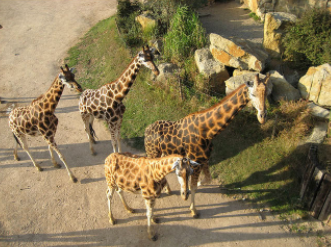

In [15]:
Image.open('./png/example.png')

In [10]:
!python sample.py --image='png/example.png'

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth
100% 230M/230M [00:04<00:00, 53.5MB/s]
<start> a group of giraffes standing next to each other . <end>


>「隣同士に立っているキリンのグループ」

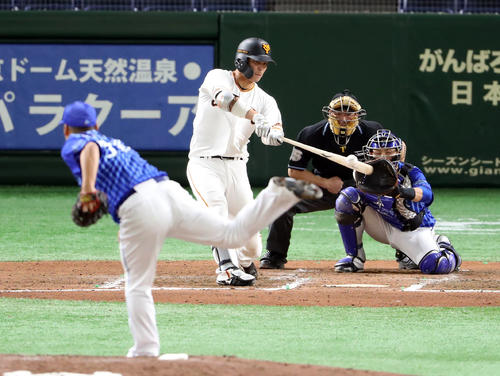

In [19]:
Image.open('img/baseball.jpg')

In [16]:
!python sample.py --image='img/baseball.jpg'

<start> a baseball player swinging a bat at a ball <end>


>「ボールでバットを振る野球選手」

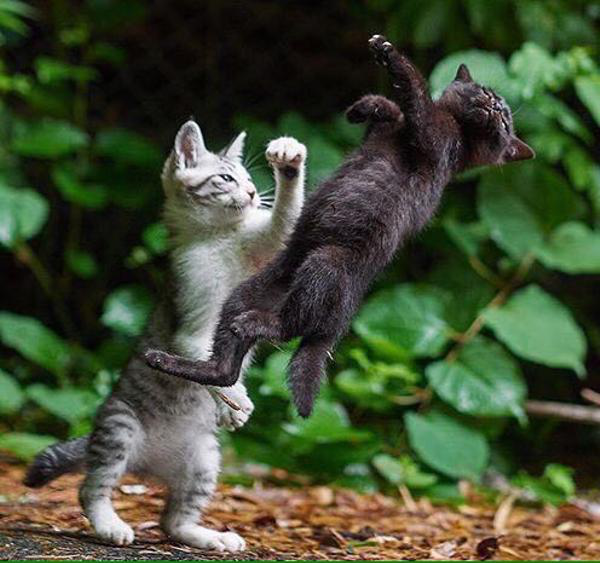

In [20]:
Image.open('img/cats.jpg')

In [17]:
!python sample.py --image='img/cats.jpg'

<start> a cat sitting on a wooden bench next to a tree . <end>


>「木の横にある木製のベンチに座っている猫」

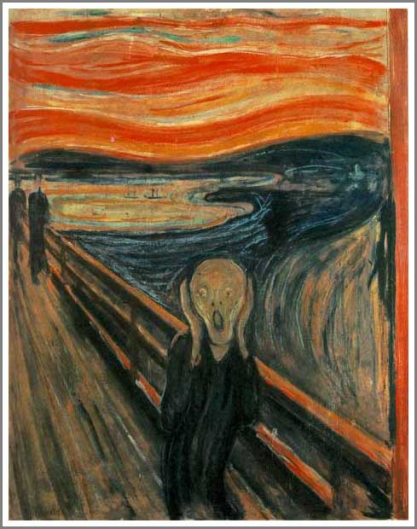

In [21]:
Image.open('img/Scream.jpg')

In [18]:
!python sample.py --image='img/Scream.jpg'

<start> a pair of scissors sitting on top of a wooden table . <end>


>「木製のテーブルの上に座っているはさみのペア」

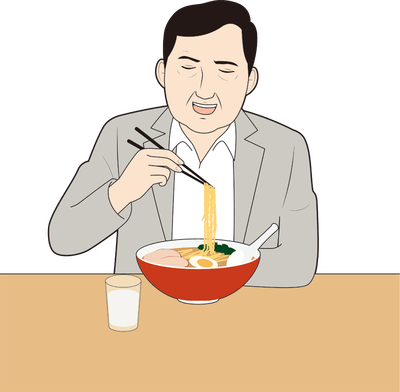

In [23]:
Image.open('img/ra_men.png')

In [24]:
!python sample.py --image='img/ra_men.png'

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
<start> a person holding a piece of cake on a plate . <end>


>皿にケーキを持っている人

# 【問題3】Kerasで動かしたい場合はどうするかを調査
PyTorchによる実装を動かしましたが、何らかの理由からKerasで動かしたい状況が考えられます。どういった手順を踏むことになるか調査し、できるだけ詳しく説明してください。


特に今回はPyTorchのための学習済みの重みをKerasで使えるようにしたいので、その点については必ず触れてください。

### パターン１
1. PyTorchで、学習済みモデルをONNX形式に変換して保存する.
2. ONNX形式のモデルをKerasのモデルに変換する.

```python
# 1. PyTorchで、学習済みモデルをONNX形式に変換して保存する.
# モデルの初期化と学習済みweightの読み込み、モデルの整形
model = mobilenetv3_large()

state_dict = torch.load('./data/pretrained/mobilenetv3-large-657e7b3d.pth', map_location='cpu')
model.clean_and_load_state_dict(state_dict)

model.convert_se()

# ONNX形式でのモデルの保存
onnx_model_path = './data/model.onnx'
dummy_input = torch.randn(1, 3, 224, 224)
input_names = ['image_array']  # ここで指定する名前が、後々saved_model.pbにする時のinput名になる
output_names = ['category']    # ここで指定する名前が、後々saved_model.pbにする時のoutput名になる

torch.onnx.export(model, dummy_input, onnx_model_path,
                  input_names=input_names, output_names=output_names)
```

```python
# 2. ONNX形式のモデルをKerasのモデルに変換する.
import onnx
from onnx2keras import onnx_to_keras
import tensorflow as tf
from tensorflow.python.keras import backend as K


sess = tf.Session()
K.set_session(sess)

onnx_model = onnx.load('./data/model.onnx')

input_names = ['image_array']
# change_ordering=True で NCHW形式のモデルをNHWC形式のモデルに変換できる
k_model = onnx_to_keras(onnx_model=onnx_model, input_names=input_names,
                        change_ordering=True, verbose=False)

# 後々weightを再ロードするためにとっておく
weights = k_model.get_weights()

# saved_model.pbへと保存する
K.set_learning_phase(0)
with K.get_session() as sess:
    # FailedPreconditionErrorを回避するために必要
    init = tf.global_variables_initializer()
    sess.run(init)

    # このままだとweightの情報が消えているのでweightを再ロード
    k_model.set_weights(weights)

    tf.saved_model.simple_save(
        sess,
        str(saved_model_dir.joinpath('1')),
        inputs={'image_array': k_model.input},
        outputs={'category_id': k_model.output}
    )
```

### パターン２
pytorch2kerasを利用する。
[pytorch2keras](https://github.com/nerox8664/pytorch2keras)